In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb

In [2]:
# dataset used
# replace with Zach's df
df2 = pd.read_csv("/kaggle/input/preprocessing-data-classical-ml-team/0.05percent_2classes_processed.csv")
df8 = pd.read_csv("/kaggle/input/preprocessing-data-classical-ml-team/0.05percent_8classes_processed.csv")
df34 = pd.read_csv("/kaggle/input/preprocessing-data-classical-ml-team/0.05percent_34classes_processed.csv")

In [3]:
# creating dataframes to store result metrics
columns = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN", "BSVM", "WSVM", "XGBoost", "Random Forest", "Random Forest - Weight", "Random Forest - Bagging"]
index = ["Accuracy", "Recall", "Precision", "F1-Score"]

metrics_2 = pd.DataFrame(index=index, columns=columns)
metrics_8 = pd.DataFrame(index=index, columns=columns)
metrics_34 = pd.DataFrame(index=index, columns=columns)

# Processing and Splitting our dataset Function
80% Train 20% Test

In [4]:
# Let's try sampling 400k datapoints

def split(df_name):
    if df_name == "df2":
        label = "benign"
        df = df2.sample(n=400000, random_state=42)
    else:
        label = "label"
        if df_name == "df8": df = df8.sample(n=400000, random_state=42)
        else: df = df34.sample(n=400000, random_state=42)
    
    # Sorting our dataset into features and target
    X = df.drop(label, axis = 1)
    y = df[label]
    
    # splitting out dataset to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    # scaling our features
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.fit_transform(X_test)
    
    # encoding for XGBoost
    encoder = LabelEncoder()
    encoded_y_train = encoder.fit_transform(y_train)
    encoded_y_test = encoder.fit_transform(y_test)
    
    return scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test

# Evaluation Functions

In [5]:
# displays the Classification Report and Confusion Matrix
# inserts the metrics of the model into the metrics dataframe
def evaluate(model, y_test, target_names, classes, model_name):
    pred = model.predict(scaled_X_test)
    
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred, average='macro')
    precision = precision_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    insert_metrics(classes, model_name, [accuracy, recall, precision, f1])
    
    if model_name == "XGBoost":
        print(classification_report(y_test, pred, target_names = target_names, digits = 3))
        
        if classes == 2 or classes == 8:
            plt.figure(figsize = (4, 2), dpi = 300)
            ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2), 
                                   display_labels = target_names).plot()
            plt.xticks(rotation=90);
    else:
        print(classification_report(y_test, pred, digits = 3))
        
        if classes == 2 or classes == 8:
            plt.figure(figsize = (4, 2), dpi = 300)
            ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2), 
                                   display_labels = target_names).plot()
            plt.xticks(rotation=90);

In [6]:
# inserts the metrics of the model into the metrics dataframe
def insert_metrics(classes, model_name, metrics):
    if classes == 2:
        metrics_2.loc['Accuracy':'F1-Score', model_name] = metrics
    elif classes == 8:
        metrics_8.loc['Accuracy':'F1-Score', model_name] = metrics
    else:
        metrics_34.loc['Accuracy':'F1-Score', model_name] = metrics

In [7]:
# inspired from Zach
def get_weights(y_train):
    import math
    
    # Get counts in log10
    y_train_count = y_train.value_counts()
    y_log = y_train_count.apply(lambda x: math.log10(x))
    
    # Find the factor needed to bring minority classes to majority
    y_log_max = y_log.max()
    y_log = y_log.apply(lambda x: math.pow(10,y_log_max - x))
    
    weight_dict = y_log.to_dict()
    
    return weight_dict

# 2 Classes

In [8]:
scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test = split("df2")

In [9]:
weight_dict = get_weights(y_train)
weight_dict

{False: 1.0, True: 41.6552919221541}

In [10]:
# essential for XGBoost
target_names = ["Attack", "Benign"]

## Logistic Regression

              precision    recall  f1-score   support

       False      0.992     0.995     0.994     78124
        True      0.764     0.687     0.723      1876

    accuracy                          0.988     80000
   macro avg      0.878     0.841     0.859     80000
weighted avg      0.987     0.988     0.987     80000



<Figure size 1200x600 with 0 Axes>

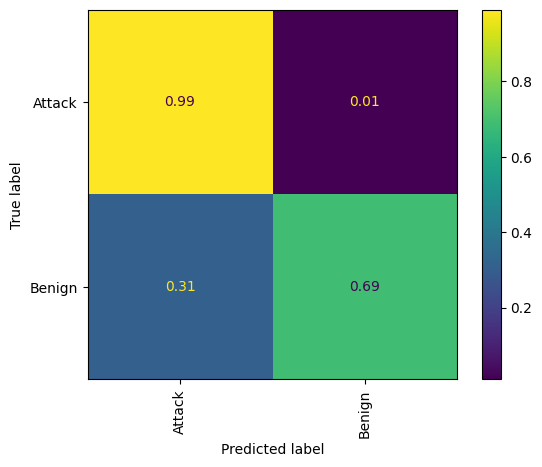

In [11]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 2, "Logistic Regression")

# Adaboost

              precision    recall  f1-score   support

       False      0.986     0.998     0.992     78124
        True      0.844     0.399     0.542      1876

    accuracy                          0.984     80000
   macro avg      0.915     0.698     0.767     80000
weighted avg      0.982     0.984     0.981     80000



<Figure size 1200x600 with 0 Axes>

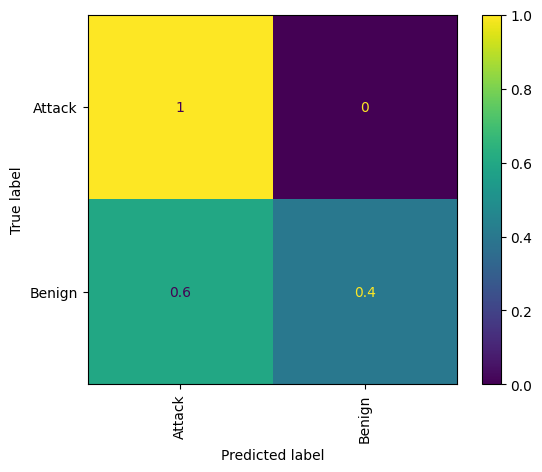

In [12]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=42)
clf.fit(scaled_X_train, y_train)

evaluate(clf, y_test, target_names, 2, "Adaboost")

# Gradientboost

              precision    recall  f1-score   support

       False      0.984     0.998     0.991     78124
        True      0.826     0.324     0.465      1876

    accuracy                          0.983     80000
   macro avg      0.905     0.661     0.728     80000
weighted avg      0.980     0.983     0.979     80000



<Figure size 1200x600 with 0 Axes>

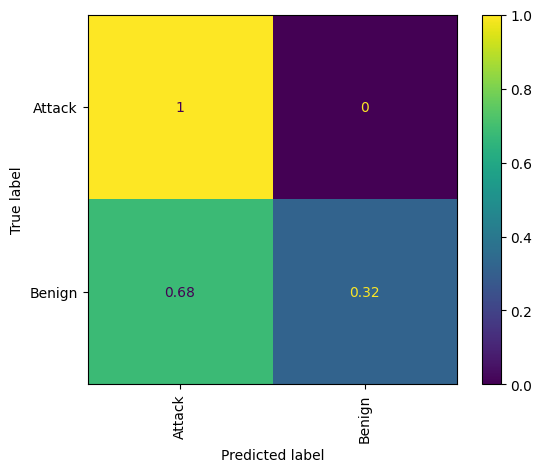

In [13]:
gbc = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1, max_depth = None)
gbc.fit(scaled_X_train, y_train)

evaluate(gbc, y_test, target_names, 2, "Gradientboost")

# KNN

              precision    recall  f1-score   support

       False      0.996     0.995     0.996     78124
        True      0.803     0.830     0.817      1876

    accuracy                          0.991     80000
   macro avg      0.900     0.913     0.906     80000
weighted avg      0.991     0.991     0.991     80000



<Figure size 1200x600 with 0 Axes>

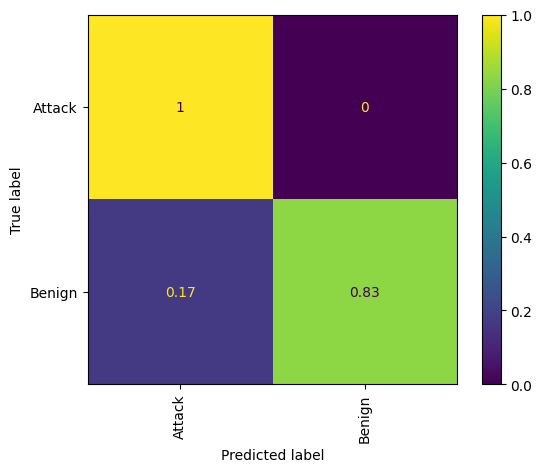

In [14]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 2, "KNN")

## Balanced SVM

              precision    recall  f1-score   support

       False      1.000     0.988     0.994     78124
        True      0.672     0.992     0.801      1876

    accuracy                          0.988     80000
   macro avg      0.836     0.990     0.898     80000
weighted avg      0.992     0.988     0.990     80000



<Figure size 1200x600 with 0 Axes>

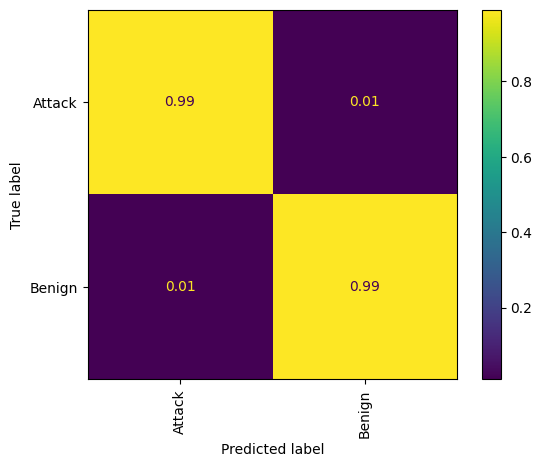

In [15]:
# Balanced Support Vector Machines
svc = SVC(C=1, kernel = "rbf", class_weight = "balanced", gamma = "scale")
svc.fit(scaled_X_train, y_train)

evaluate(svc, y_test, target_names, 2, "BSVM")

## Weighted SVM

              precision    recall  f1-score   support

       False      1.000     0.989     0.994     78124
        True      0.688     0.986     0.810      1876

    accuracy                          0.989     80000
   macro avg      0.844     0.987     0.902     80000
weighted avg      0.992     0.989     0.990     80000



<Figure size 1200x600 with 0 Axes>

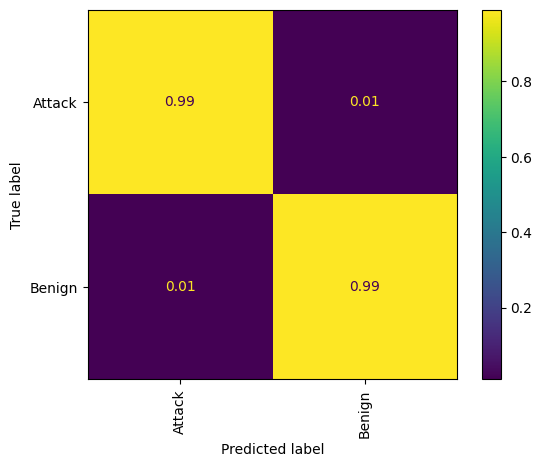

In [16]:
# Weighted Support Vector Machines
svc = SVC(C=1, kernel = "rbf", class_weight = weight_dict, gamma = "scale")
svc.fit(scaled_X_train, y_train)

evaluate(svc, y_test, target_names, 2, "WSVM")

# XGBoost

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:54:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_samples" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

      Attack      0.984     0.998     0.991     78124
      Benign      0.780     0.338     0.472      1876

    accuracy                          0.982     80000
   macro avg      0.882     0.668     0.731     80000
weighted avg      0.980     0.982     0.979     80000



<Figure size 1200x600 with 0 Axes>

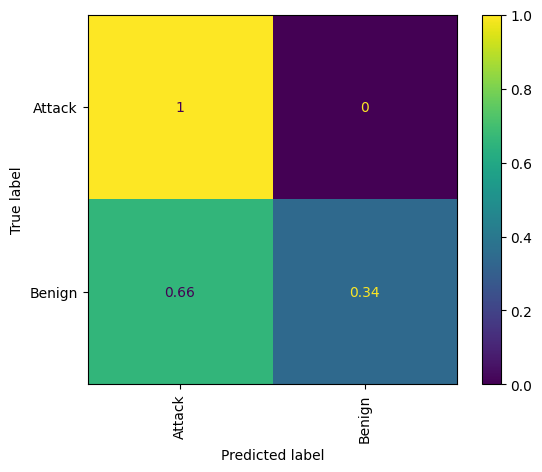

In [17]:
xgc = xgb.XGBClassifier(n_estimators=100, learning_rate = 1, booster = "gbtree", random_state = 42,
                       max_depth = 13, max_samples = 0.9)
xgc.fit(scaled_X_train, encoded_y_train)

evaluate(xgc, encoded_y_test, target_names, 2, "XGBoost")

# Random Forest

              precision    recall  f1-score   support

       False      0.986     0.999     0.992     78124
        True      0.893     0.409     0.561      1876

    accuracy                          0.985     80000
   macro avg      0.940     0.704     0.777     80000
weighted avg      0.984     0.985     0.982     80000



<Figure size 1200x600 with 0 Axes>

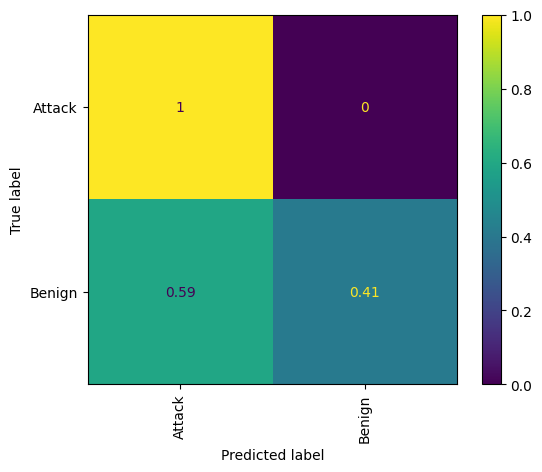

In [18]:
# Base RF
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 2, "Random Forest")

              precision    recall  f1-score   support

       False      0.986     0.999     0.992     78124
        True      0.897     0.394     0.548      1876

    accuracy                          0.985     80000
   macro avg      0.941     0.697     0.770     80000
weighted avg      0.984     0.985     0.982     80000



<Figure size 1200x600 with 0 Axes>

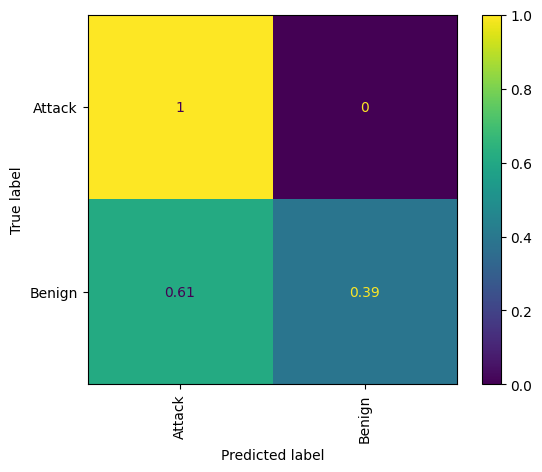

In [19]:
# Weight-balanced
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 2, "Random Forest - Weight")

              precision    recall  f1-score   support

       False      0.988     0.991     0.990     78124
        True      0.580     0.500     0.537      1876

    accuracy                          0.980     80000
   macro avg      0.784     0.746     0.763     80000
weighted avg      0.978     0.980     0.979     80000



<Figure size 1200x600 with 0 Axes>

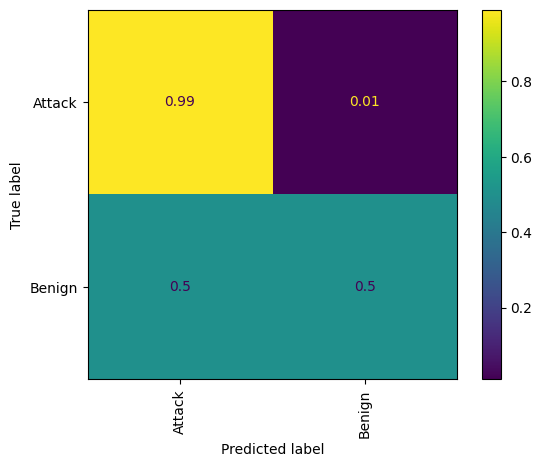

In [20]:
# Bagging-balanced
rfc = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 2, "Random Forest - Bagging")

In [21]:
# exporting and displaying the class 2 metrics
metrics_2.to_csv('metrics_2.csv', index=True)
metrics_2

,Logistic Regression,Adaboost,Gradientboost,KNN,BSVM,WSVM,XGBoost,Random Forest,Random Forest - Weight,Random Forest - Bagging
Accuracy,0.987688,0.984175,0.982537,0.99125,0.988463,0.989187,0.982237,0.985,0.984738,0.979775
Recall,0.840743,0.698477,0.660961,0.9128,0.990191,0.987441,0.667831,0.704102,0.696684,0.745648
Precision,0.878442,0.914993,0.90492,0.899509,0.835945,0.843889,0.882072,0.939511,0.941311,0.783881
F1-Score,0.858548,0.766793,0.72804,0.90604,0.897675,0.902433,0.731259,0.776887,0.770091,0.763291


# 8 Classes

In [22]:
scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test = split("df8")

In [23]:
weight_dict = get_weights(y_train)
weight_dict

{'DDoS': 1.0,
 'DoS': 4.217345664488805,
 'Mirai': 12.836500853853368,
 'Benign': 31.061183684350862,
 'Spoofing': 68.8392909896603,
 'Recon': 95.61797291752158,
 'Web': 1429.5766871165652,
 'BruteForce': 2709.5465116279092}

In [24]:
y_test.value_counts()

label
DDoS          58255
DoS           13813
Mirai          4538
Benign         1876
Spoofing        846
Recon           609
Web              41
BruteForce       22
Name: count, dtype: int64

In [25]:
# essential for XGBoost
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]

## Logistic Regression

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

              precision    recall  f1-score   support

      Benign      0.697     0.886     0.780      1876
  BruteForce      0.333     0.045     0.080        22
        DDoS      0.824     0.991     0.900     58255
         DoS      0.693     0.114     0.196     13813
       Mirai      0.991     0.992     0.992      4538
       Recon      0.535     0.289     0.375       609
    Spoofing      0.769     0.362     0.492       846
         Web      0.000     0.000     0.000        41

    accuracy                          0.825     80000
   macro avg      0.605     0.460     0.477     80000
weighted avg      0.805     0.825     0.772     80000



<Figure size 1200x600 with 0 Axes>

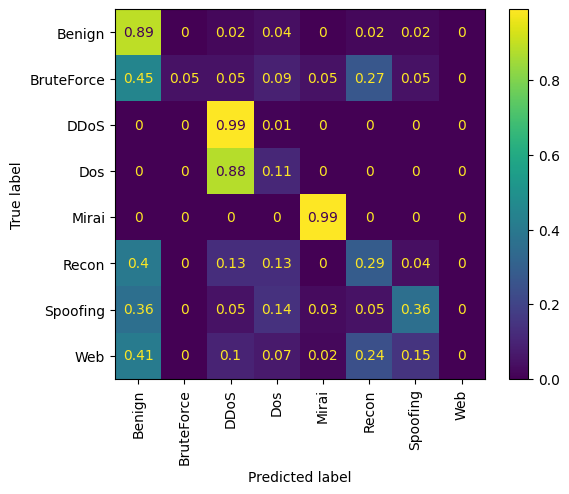

In [26]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 8, "Logistic Regression")

## Adaboost

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

              precision    recall  f1-score   support

      Benign      0.605     0.328     0.426      1876
  BruteForce      0.000     0.000     0.000        22
        DDoS      0.683     0.145     0.239     58255
         DoS      0.162     0.721     0.265     13813
       Mirai      0.837     0.627     0.717      4538
       Recon      0.271     0.539     0.361       609
    Spoofing      0.391     0.275     0.323       846
         Web      0.027     0.049     0.035        41

    accuracy                          0.280     80000
   macro avg      0.372     0.335     0.296     80000
weighted avg      0.593     0.280     0.277     80000



<Figure size 1200x600 with 0 Axes>

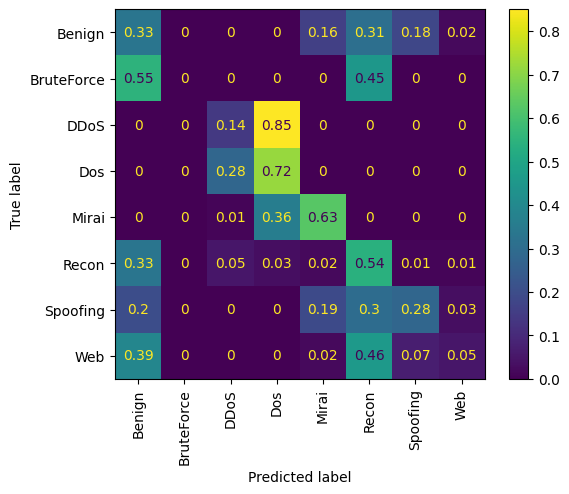

In [27]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=42)
clf.fit(scaled_X_train, y_train)

evaluate(clf, y_test, target_names, 8, "Adaboost")

## Gradientboost

              precision    recall  f1-score   support

      Benign      0.022     0.002     0.003      1876
  BruteForce      0.167     0.045     0.071        22
        DDoS      0.811     0.977     0.886     58255
         DoS      0.965     0.046     0.087     13813
       Mirai      0.628     1.000     0.771      4538
       Recon      0.489     0.245     0.326       609
    Spoofing      0.292     0.496     0.368       846
         Web      0.132     0.293     0.182        41

    accuracy                          0.783     80000
   macro avg      0.438     0.388     0.337     80000
weighted avg      0.800     0.783     0.711     80000



<Figure size 1200x600 with 0 Axes>

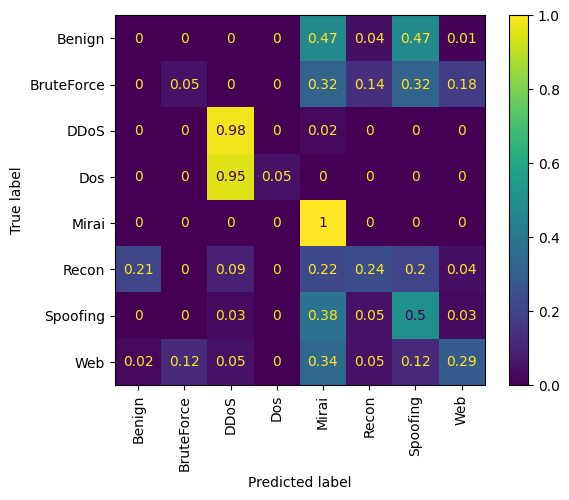

In [28]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate = 1, max_depth = None)
gbc.fit(scaled_X_train, y_train)

evaluate(gbc, y_test, target_names, 8, "Gradientboost")

# KNN

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

              precision    recall  f1-score   support

      Benign      0.724     0.942     0.818      1876
  BruteForce      0.500     0.045     0.083        22
        DDoS      0.864     0.986     0.921     58255
         DoS      0.857     0.347     0.494     13813
       Mirai      0.997     0.994     0.995      4538
       Recon      0.725     0.519     0.605       609
    Spoofing      0.785     0.474     0.591       846
         Web      0.000     0.000     0.000        41

    accuracy                          0.865     80000
   macro avg      0.681     0.538     0.563     80000
weighted avg      0.864     0.865     0.842     80000



<Figure size 1200x600 with 0 Axes>

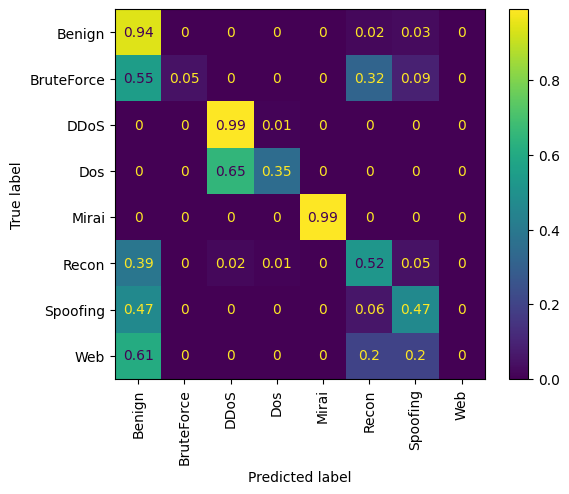

In [29]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 8, "KNN")

## Balanced SVM

              precision    recall  f1-score   support

      Benign      0.834     0.808     0.821      1876
  BruteForce      0.009     0.045     0.015        22
        DDoS      0.949     0.645     0.768     58255
         DoS      0.364     0.851     0.510     13813
       Mirai      0.989     0.995     0.992      4538
       Recon      0.527     0.596     0.559       609
    Spoofing      0.707     0.615     0.657       846
         Web      0.052     0.220     0.084        41

    accuracy                          0.703     80000
   macro avg      0.554     0.597     0.551     80000
weighted avg      0.841     0.703     0.734     80000



<Figure size 1200x600 with 0 Axes>

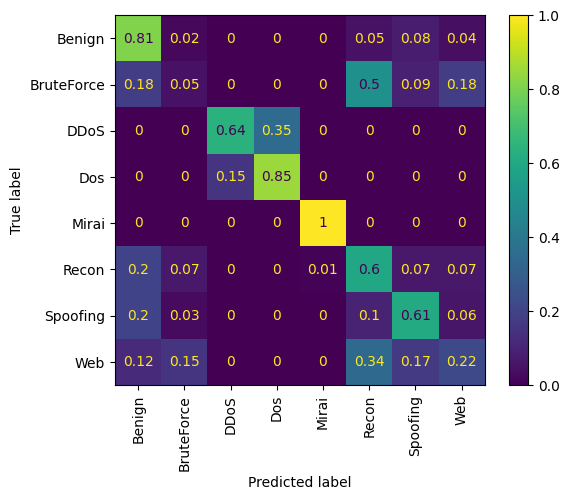

In [30]:
# Balanced Support Vector Machines
svc = SVC(C=1, kernel = "rbf", class_weight = "balanced", gamma = "scale")
svc.fit(scaled_X_train, y_train)

evaluate(svc, y_test, target_names, 8, "BSVM")

# Weighted SVM

              precision    recall  f1-score   support

      Benign      0.813     0.807     0.810      1876
  BruteForce      0.016     0.045     0.024        22
        DDoS      0.959     0.700     0.809     58255
         DoS      0.410     0.874     0.558     13813
       Mirai      0.989     0.996     0.992      4538
       Recon      0.545     0.612     0.577       609
    Spoofing      0.693     0.612     0.650       846
         Web      0.082     0.220     0.119        41

    accuracy                          0.747     80000
   macro avg      0.563     0.608     0.567     80000
weighted avg      0.856     0.747     0.772     80000



<Figure size 1200x600 with 0 Axes>

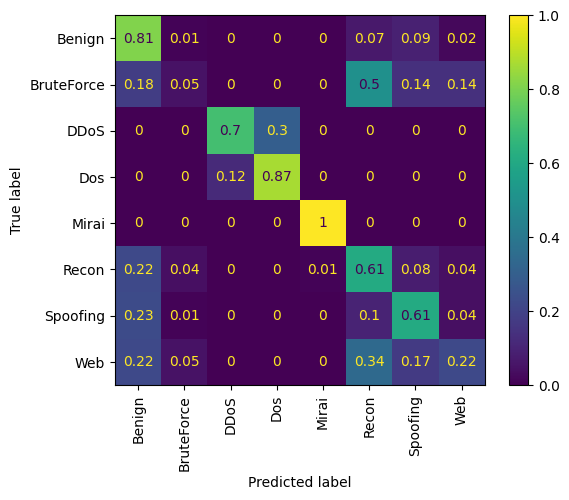

In [31]:
# Weighted Support Vector Machines
svc = SVC(C=1, kernel = "rbf", class_weight = weight_dict, gamma = "scale")
svc.fit(scaled_X_train, y_train)

evaluate(svc, y_test, target_names, 8, "WSVM")

## XGBoost

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:30:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_samples" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

      Benign      0.783     0.530     0.632      1876
  BruteForce      0.050     0.045     0.048        22
        DDoS      0.811     0.977     0.887     58255
         Dos      0.946     0.047     0.089     13813
       Mirai      0.779     0.999     0.875      4538
       Recon      0.620     0.484     0.544       609
    Spoofing      0.434     0.801     0.563       846
         Web      0.067     0.049     0.056        41

    accuracy                          0.801     80000
   macro avg      0.561     0.492     0.462     80000
weighted avg      0.826     0.801     0.736     80000



<Figure size 1200x600 with 0 Axes>

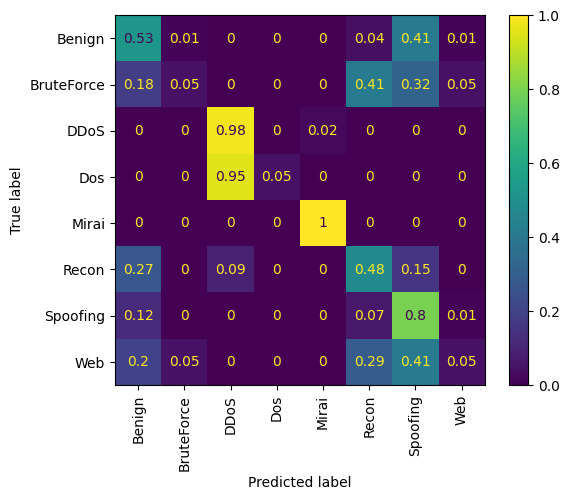

In [32]:
# Required to be trained on scaled_X_train, encoded_y_train
# evaluate parameter for y_test to be encoded y_test
xgc = xgb.XGBClassifier(n_estimators=100, learning_rate = 1, booster = "gbtree", random_state = 42,
                       max_depth = 13, max_samples = 0.9)
xgc.fit(scaled_X_train, encoded_y_train)

evaluate(xgc, encoded_y_test, target_names, 8, "XGBoost")

## Random Forest

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

              precision    recall  f1-score   support

      Benign      0.727     0.494     0.588      1876
  BruteForce      0.000     0.000     0.000        22
        DDoS      0.815     1.000     0.898     58255
         DoS      0.985     0.046     0.088     13813
       Mirai      0.999     0.999     0.999      4538
       Recon      0.785     0.456     0.577       609
    Spoofing      0.397     0.820     0.535       846
         Web      0.000     0.000     0.000        41

    accuracy                          0.816     80000
   macro avg      0.589     0.477     0.461     80000
weighted avg      0.848     0.816     0.750     80000



<Figure size 1200x600 with 0 Axes>

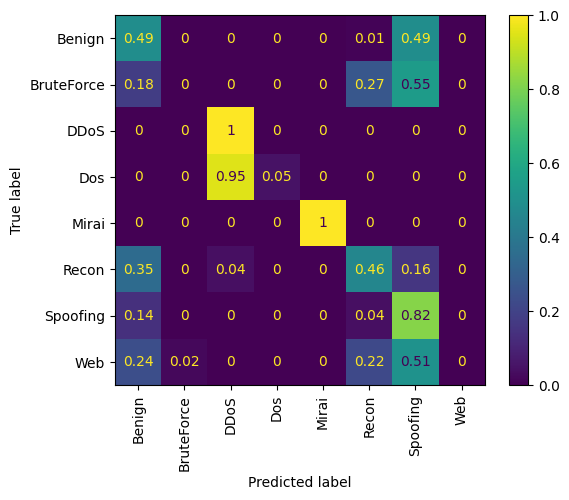

In [33]:
# Base RF
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 8, "Random Forest")

              precision    recall  f1-score   support

      Benign      0.690     0.504     0.583      1876
  BruteForce      0.000     0.000     0.000        22
        DDoS      0.816     0.999     0.898     58255
         DoS      0.978     0.051     0.098     13813
       Mirai      1.000     0.996     0.998      4538
       Recon      0.813     0.450     0.579       609
    Spoofing      0.392     0.778     0.521       846
         Web      1.000     0.146     0.255        41

    accuracy                          0.817     80000
   macro avg      0.711     0.491     0.492     80000
weighted avg      0.847     0.817     0.751     80000



<Figure size 1200x600 with 0 Axes>

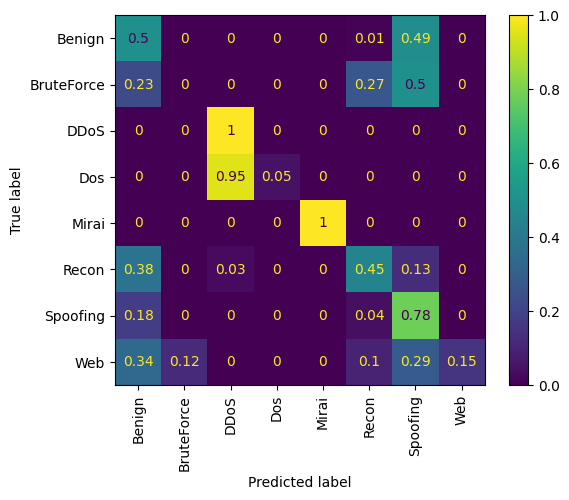

In [34]:
# Weight-balanced
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 8, "Random Forest - Weight")

              precision    recall  f1-score   support

      Benign      0.744     0.395     0.516      1876
  BruteForce      0.019     0.273     0.035        22
        DDoS      0.852     0.976     0.910     58255
         DoS      0.896     0.255     0.397     13813
       Mirai      0.998     0.988     0.993      4538
       Recon      0.283     0.517     0.366       609
    Spoofing      0.284     0.670     0.399       846
         Web      0.044     0.463     0.081        41

    accuracy                          0.831     80000
   macro avg      0.515     0.567     0.462     80000
weighted avg      0.854     0.831     0.807     80000



<Figure size 1200x600 with 0 Axes>

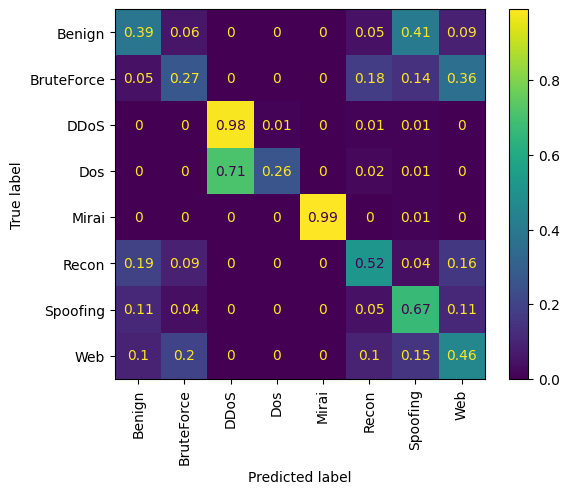

In [35]:
# Bagging-balanced
rfc = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 8, "Random Forest - Bagging")

In [36]:
# exporting and displaying the class 8 metrics
metrics_8.to_csv('metrics_8.csv', index=True)
metrics_8

,Logistic Regression,Adaboost,Gradientboost,KNN,BSVM,WSVM,XGBoost,Random Forest,Random Forest - Weight,Random Forest - Bagging
Accuracy,0.824525,0.280237,0.783125,0.865337,0.703113,0.747212,0.80085,0.816338,0.816725,0.831275
Recall,0.460009,0.335463,0.387857,0.538328,0.596797,0.608275,0.491619,0.476953,0.490632,0.56721
Precision,0.605266,0.372094,0.438225,0.681374,0.553757,0.563167,0.561227,0.588554,0.711089,0.514969
F1-Score,0.476911,0.295643,0.336922,0.563449,0.550759,0.567329,0.461796,0.460737,0.491565,0.462115


# 34 Classes

In [37]:
scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test = split("df34")

In [38]:
weight_dict = get_weights(y_train)
weight_dict

{'DDoS-ICMP_Flood': 1.0,
 'DDoS-UDP_Flood': 1.3327485222273208,
 'DDoS-TCP_Flood': 1.6057560975609746,
 'DDoS-PSHACK_Flood': 1.7570010319182976,
 'DDoS-SYN_Flood': 1.7736628470850218,
 'DDoS-RSTFINFlood': 1.7863680764082344,
 'DDoS-SynonymousIP_Flood': 1.9886825889081294,
 'DoS-UDP_Flood': 2.1790379523389207,
 'DoS-TCP_Flood': 2.6990816661200356,
 'DoS-SYN_Flood': 3.578302775563443,
 'BenignTraffic': 6.580967612954817,
 'Mirai-greeth_flood': 7.218859649122804,
 'Mirai-udpplain': 7.982056256062071,
 'Mirai-greip_flood': 9.630778232884722,
 'DDoS-ICMP_Fragmentation': 15.928064516129023,
 'MITM-ArpSpoofing': 23.291037735849052,
 'DDoS-UDP_Fragmentation': 24.299704724409448,
 'DDoS-ACK_Fragmentation': 25.452061855670088,
 'DNS_Spoofing': 39.03320158102764,
 'Recon-HostDiscovery': 52.58466453674118,
 'Recon-OSScan': 73.04289940828397,
 'Recon-PortScan': 87.85943060498215,
 'DoS-HTTP_Flood': 98.95190380761521,
 'VulnerabilityScan': 201.5387755102039,
 'DDoS-HTTP_Flood': 259.87894736842094,
 

In [39]:
y_test.value_counts()

label
DDoS-ICMP_Flood            12344
DDoS-UDP_Flood              9262
DDoS-TCP_Flood              7687
DDoS-PSHACK_Flood           7026
DDoS-SYN_Flood              6960
DDoS-RSTFINFlood            6910
DDoS-SynonymousIP_Flood     6207
DoS-UDP_Flood               5665
DoS-TCP_Flood               4574
DoS-SYN_Flood               3450
BenignTraffic               1875
Mirai-greeth_flood          1710
Mirai-udpplain              1546
Mirai-greip_flood           1282
DDoS-ICMP_Fragmentation      775
MITM-ArpSpoofing             530
DDoS-UDP_Fragmentation       508
DDoS-ACK_Fragmentation       485
DNS_Spoofing                 316
Recon-HostDiscovery          235
Recon-OSScan                 169
Recon-PortScan               140
DoS-HTTP_Flood               125
VulnerabilityScan             61
DDoS-HTTP_Flood               48
DDoS-SlowLoris                43
DictionaryBruteForce          22
BrowserHijacking              11
SqlInjection                  10
CommandInjection               9
XSS 

In [40]:
# essential for XGBoost
target_names = list(y_test.unique())

## Logistic Regression

In [41]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 34, "Logistic Regression")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.659     0.937     0.774      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.898     0.163     0.276       485
        DDoS-HTTP_Flood      0.455     0.417     0.435        48
        DDoS-ICMP_Flood      0.973     0.995     0.984     12344
DDoS-ICMP_Fragmentation      0.614     0.982     0.755       775
      DDoS-PSHACK_Flood      1.000     0.983     0.991      7026
       DDoS-RSTFINFlood      1.000     0.999     0.999      6910
         DDoS-SYN_Flood      0.647     0.967     0.775      6960
         DDoS-SlowLoris      0.500     0.163     0.246        43
DDoS-SynonymousIP_Flood      0.749     0.669     0.707      6207
         DDoS-TCP_Flood      0.612     0.944     0.743      7687
         DDoS-UDP_Flood 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Adaboost

In [42]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=42)
clf.fit(scaled_X_train, y_train)

evaluate(clf, y_test, target_names, 34, "Adaboost")

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.511     0.507     0.509      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.000     0.000     0.000       485
        DDoS-HTTP_Flood      0.000     0.000     0.000        48
        DDoS-ICMP_Flood      0.974     0.994     0.984     12344
DDoS-ICMP_Fragmentation      0.000     0.000     0.000       775
      DDoS-PSHACK_Flood      0.917     0.039     0.075      7026
       DDoS-RSTFINFlood      0.999     0.995     0.997      6910
         DDoS-SYN_Flood      0.300     0.996     0.461      6960
         DDoS-SlowLoris      0.000     0.000     0.000        43
DDoS-SynonymousIP_Flood      0.333     0.000     0.001      6207
         DDoS-TCP_Flood      0.480     0.052     0.093      7687
         DDoS-UDP_Flood 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Gradientboost

In [43]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate = 1, max_depth = None)
gbc.fit(scaled_X_train, y_train)

evaluate(gbc, y_test, target_names, 34, "Gradientboost")

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.091     0.250     0.133         4
          BenignTraffic      0.522     0.216     0.306      1875
       BrowserHijacking      0.020     0.545     0.039        11
       CommandInjection      0.029     0.111     0.045         9
 DDoS-ACK_Fragmentation      0.076     0.010     0.018       485
        DDoS-HTTP_Flood      0.286     0.042     0.073        48
        DDoS-ICMP_Flood      0.996     0.997     0.996     12344
DDoS-ICMP_Fragmentation      0.626     0.975     0.762       775
      DDoS-PSHACK_Flood      0.488     0.998     0.655      7026
       DDoS-RSTFINFlood      0.996     0.997     0.996      6910
         DDoS-SYN_Flood      0.124     0.036     0.056      6960
         DDoS-SlowLoris      0.375     0.070     0.118        43
DDoS-SynonymousIP_Flood      0.222     0.001     0.001      6207
         DDoS-TCP_Flood      0.194     0.437     0.269      7687
         DDoS-UDP_Flood 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNN

In [44]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 34, "KNN")

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.712     0.958     0.817      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.667     0.672     0.669       485
        DDoS-HTTP_Flood      0.667     0.583     0.622        48
        DDoS-ICMP_Flood      0.988     0.994     0.991     12344
DDoS-ICMP_Fragmentation      0.743     0.819     0.779       775
      DDoS-PSHACK_Flood      1.000     0.995     0.998      7026
       DDoS-RSTFINFlood      1.000     0.999     0.999      6910
         DDoS-SYN_Flood      0.898     0.956     0.926      6960
         DDoS-SlowLoris      0.571     0.744     0.646        43
DDoS-SynonymousIP_Flood      0.963     0.939     0.950      6207
         DDoS-TCP_Flood      0.934     0.963     0.948      7687
         DDoS-UDP_Flood 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Balanced SVM

In [45]:
# Balanced Support Vector Machines
svc = SVC(C=1, kernel = "rbf", class_weight = "balanced", gamma = "scale")
svc.fit(scaled_X_train, y_train)

evaluate(svc, y_test, target_names, 34, "BSVM")

                         precision    recall  f1-score   support

       Backdoor_Malware      0.056     0.250     0.091         4
          BenignTraffic      0.853     0.688     0.762      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.553     0.672     0.607       485
        DDoS-HTTP_Flood      0.234     0.771     0.359        48
        DDoS-ICMP_Flood      0.971     0.992     0.981     12344
DDoS-ICMP_Fragmentation      0.750     0.681     0.714       775
      DDoS-PSHACK_Flood      1.000     0.983     0.991      7026
       DDoS-RSTFINFlood      1.000     0.999     1.000      6910
         DDoS-SYN_Flood      0.648     0.951     0.770      6960
         DDoS-SlowLoris      0.333     0.767     0.465        43
DDoS-SynonymousIP_Flood      0.770     0.648     0.704      6207
         DDoS-TCP_Flood      0.644     0.870     0.740      7687
         DDoS-UDP_Flood 

## Weighted SVM

In [46]:
# Weighted Support Vector Machines
svc = SVC(C=1, kernel = "rbf", class_weight = weight_dict, gamma = "scale")
svc.fit(scaled_X_train, y_train)

evaluate(svc, y_test, target_names, 34, "WSVM")

                         precision    recall  f1-score   support

       Backdoor_Malware      0.077     0.250     0.118         4
          BenignTraffic      0.835     0.733     0.781      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.639     0.781     0.703       485
        DDoS-HTTP_Flood      0.349     0.771     0.481        48
        DDoS-ICMP_Flood      0.971     0.996     0.983     12344
DDoS-ICMP_Fragmentation      0.819     0.735     0.775       775
      DDoS-PSHACK_Flood      1.000     0.983     0.991      7026
       DDoS-RSTFINFlood      1.000     0.999     1.000      6910
         DDoS-SYN_Flood      0.659     0.950     0.778      6960
         DDoS-SlowLoris      0.400     0.791     0.531        43
DDoS-SynonymousIP_Flood      0.976     0.711     0.823      6207
         DDoS-TCP_Flood      0.684     0.896     0.775      7687
         DDoS-UDP_Flood 

## XGBoost

In [47]:
xgc = xgb.XGBClassifier(n_estimators=100, learning_rate = 1, booster = "gbtree", random_state = 42,
                       max_depth = 13, max_samples = 0.9)
xgc.fit(scaled_X_train, encoded_y_train)

evaluate(xgc, encoded_y_test, target_names, 34, "XGBoost")

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:10:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_samples" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no p

                         precision    recall  f1-score   support

        DDoS-ICMP_Flood      0.000     0.000     0.000         4
         DDoS-TCP_Flood      0.460     0.119     0.190      1875
       DDoS-RSTFINFlood      0.000     0.000     0.000        11
          DoS-TCP_Flood      0.000     0.000     0.000         9
DDoS-SynonymousIP_Flood      0.000     0.000     0.000       485
         DDoS-UDP_Flood      0.000     0.000     0.000        48
      DDoS-PSHACK_Flood      0.000     0.000     0.000     12344
          DoS-SYN_Flood      0.000     0.000     0.000       775
          DoS-UDP_Flood      0.000     0.000     0.000      7026
          BenignTraffic      0.129     1.000     0.229      6910
 DDoS-UDP_Fragmentation      0.000     0.000     0.000      6960
         DDoS-SYN_Flood      0.000     0.000     0.000        43
     Mirai-greeth_flood      0.000     0.000     0.000      6207
         Mirai-udpplain      0.000     0.000     0.000      7687
      Mirai-greip_flood 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest

In [48]:
# Base RF
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 34, "Random Forest")

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.686     0.536     0.602      1875
       BrowserHijacking      0.333     0.091     0.143        11
       CommandInjection      1.000     0.111     0.200         9
 DDoS-ACK_Fragmentation      0.933     0.171     0.289       485
        DDoS-HTTP_Flood      0.891     0.854     0.872        48
        DDoS-ICMP_Flood      1.000     0.997     0.999     12344
DDoS-ICMP_Fragmentation      0.650     0.994     0.786       775
      DDoS-PSHACK_Flood      0.999     0.999     0.999      7026
       DDoS-RSTFINFlood      1.000     1.000     1.000      6910
         DDoS-SYN_Flood      0.997     0.995     0.996      6960
         DDoS-SlowLoris      0.825     0.767     0.795        43
DDoS-SynonymousIP_Flood      0.999     0.998     0.998      6207
         DDoS-TCP_Flood      0.997     0.966     0.981      7687
         DDoS-UDP_Flood 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
# Weight-balanced
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 34, "Random Forest - Weight")

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.697     0.776     0.734      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      1.000     0.333     0.500         9
 DDoS-ACK_Fragmentation      0.993     0.592     0.742       485
        DDoS-HTTP_Flood      0.971     0.688     0.805        48
        DDoS-ICMP_Flood      1.000     0.997     0.998     12344
DDoS-ICMP_Fragmentation      0.793     0.992     0.881       775
      DDoS-PSHACK_Flood      0.999     0.999     0.999      7026
       DDoS-RSTFINFlood      1.000     1.000     1.000      6910
         DDoS-SYN_Flood      0.997     0.996     0.997      6960
         DDoS-SlowLoris      0.971     0.767     0.857        43
DDoS-SynonymousIP_Flood      0.999     0.997     0.998      6207
         DDoS-TCP_Flood      0.999     0.968     0.983      7687
         DDoS-UDP_Flood 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
# Bagging-balanced
rfc = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 34, "Random Forest - Bagging")

                         precision    recall  f1-score   support

       Backdoor_Malware      0.011     0.250     0.021         4
          BenignTraffic      0.729     0.591     0.653      1875
       BrowserHijacking      0.012     0.091     0.022        11
       CommandInjection      0.400     0.222     0.286         9
 DDoS-ACK_Fragmentation      0.623     0.934     0.748       485
        DDoS-HTTP_Flood      0.094     0.562     0.161        48
        DDoS-ICMP_Flood      0.975     0.988     0.981     12344
DDoS-ICMP_Fragmentation      0.972     0.631     0.765       775
      DDoS-PSHACK_Flood      0.996     0.995     0.996      7026
       DDoS-RSTFINFlood      0.999     0.998     0.998      6910
         DDoS-SYN_Flood      0.939     0.912     0.925      6960
         DDoS-SlowLoris      0.167     0.419     0.238        43
DDoS-SynonymousIP_Flood      0.955     0.991     0.973      6207
         DDoS-TCP_Flood      0.994     0.780     0.874      7687
         DDoS-UDP_Flood 

In [51]:
# exporting and displaying the class 34 metrics
metrics_34.to_csv('metrics_34.csv', index=True)
metrics_34

,Logistic Regression,Adaboost,Gradientboost,KNN,BSVM,WSVM,XGBoost,Random Forest,Random Forest - Weight,Random Forest - Bagging
Accuracy,0.779937,0.534,0.527162,0.927,0.79345,0.825512,0.19105,0.8839,0.891225,0.889513
Recall,0.416258,0.257193,0.33412,0.581291,0.547553,0.569026,0.058803,0.583725,0.592922,0.546922
Precision,0.511458,0.238277,0.361411,0.620315,0.502462,0.535244,0.036382,0.685009,0.69852,0.539256
F1-Score,0.415968,0.195946,0.280643,0.590829,0.502505,0.536039,0.034266,0.577278,0.601756,0.499717


# Metric Plot

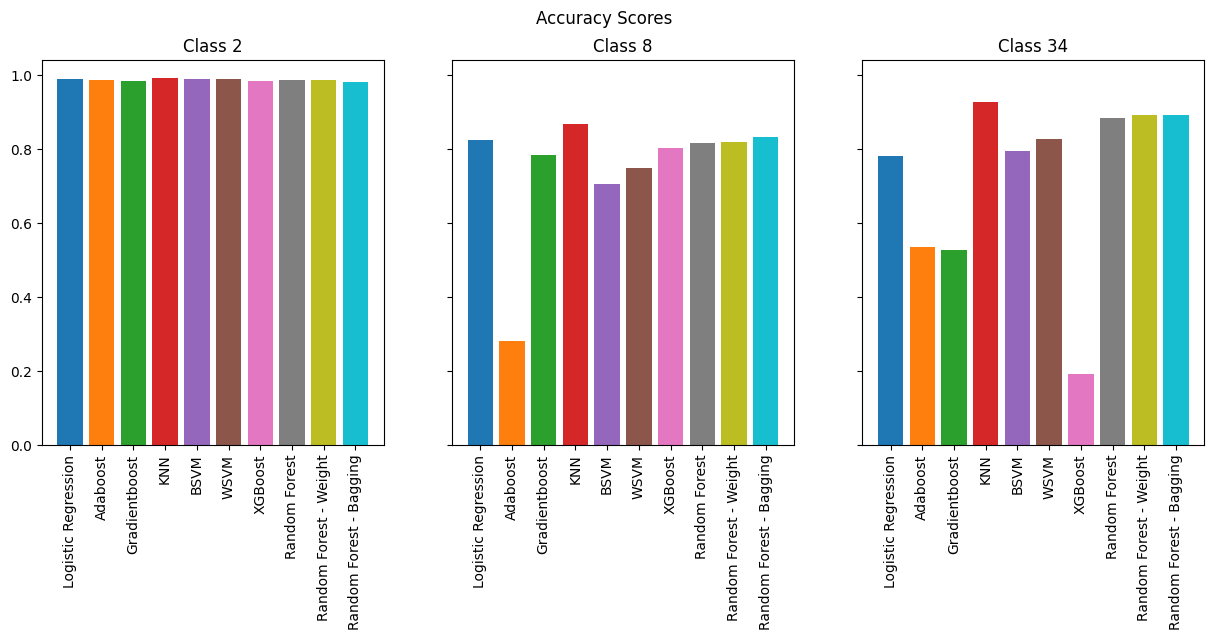

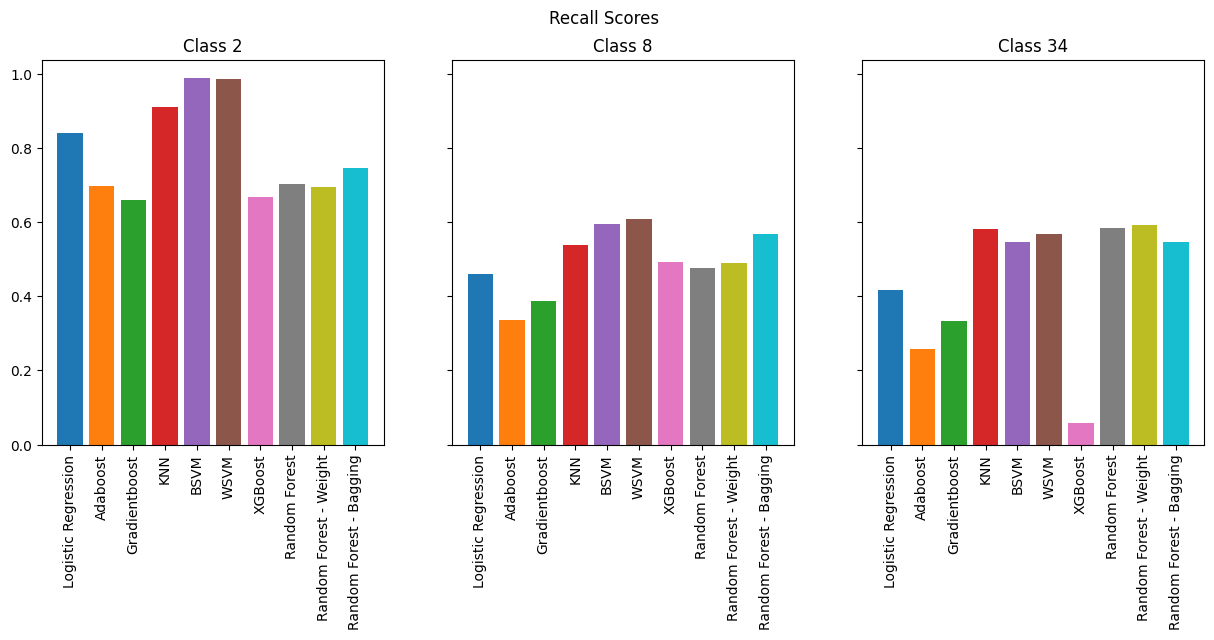

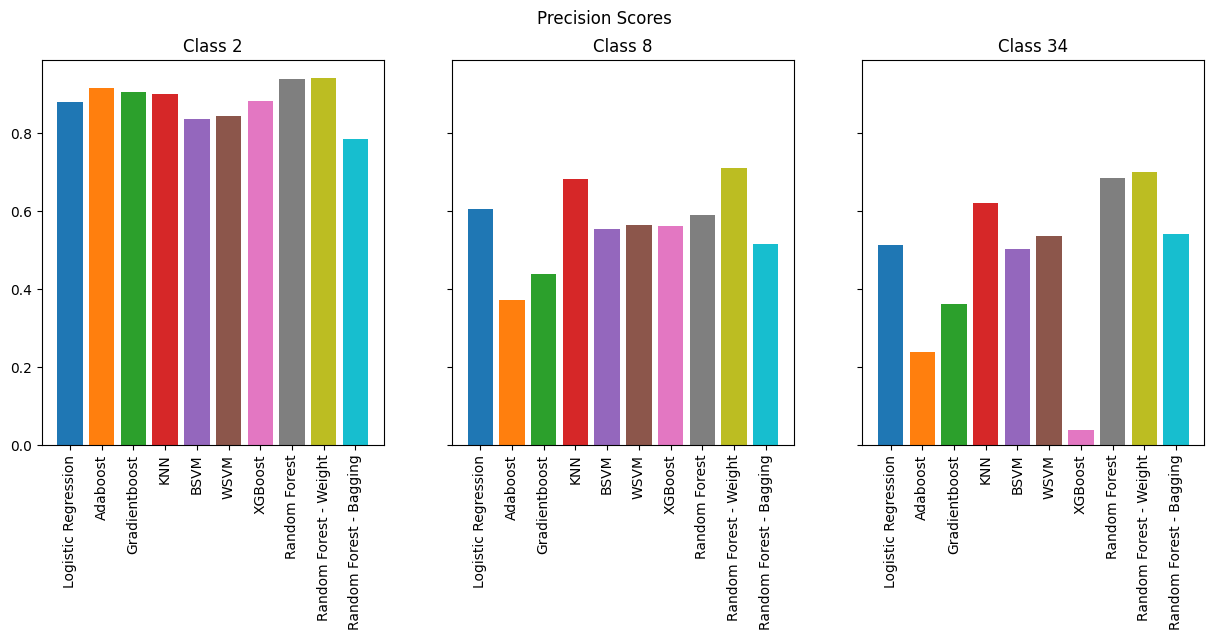

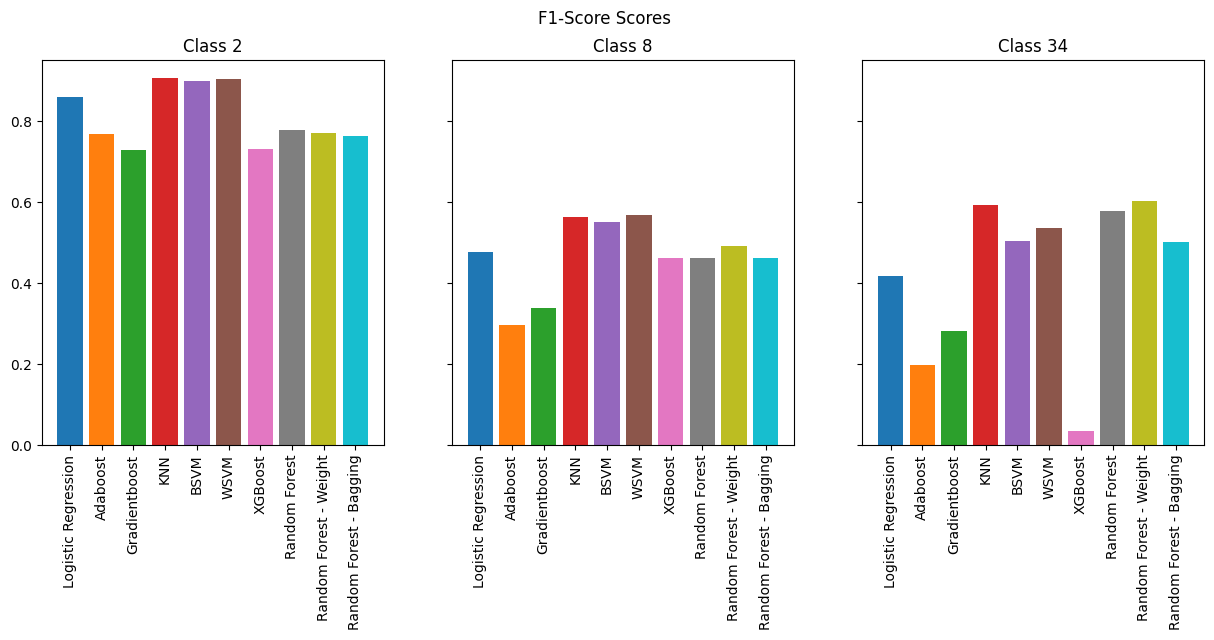

In [52]:
# List of model names
model_names = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN", "BSVM", "WSVM", "XGBoost", "Random Forest", "Random Forest - Weight", "Random Forest - Bagging"]

# List of dataframes
dataframes = [metrics_2, metrics_8, metrics_34]

# List of classes
classes = [2, 8, 34]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a color mapping dictionary for each model
model_colors = {
    "Logistic Regression": 'tab:blue',
    "Adaboost": 'tab:orange',
    "Gradientboost": 'tab:green',
    "KNN": 'tab:red',
    "BSVM": 'tab:purple',
    "WSVM": 'tab:brown',
    "XGBoost": 'tab:pink',
    "Random Forest": 'tab:gray',
    "Random Forest - Weight": 'tab:olive',
    "Random Forest - Bagging": 'tab:cyan'
}

# Creating subplots for each metric
for metric in metrics:
    fig, axs = plt.subplots(1, len(classes), figsize=(15, 5), sharey=True)
    fig.suptitle(f"{metric} Scores")

    for i, df in enumerate(dataframes):
        axs[i].set_title(f"Class {classes[i]}")
        
        # Plotting the respective metric score for each model with specified color
        for model_name in model_names:
            color = model_colors[model_name]
            axs[i].bar(model_name, df.loc[metric, model_name], color=color)
        
        # Set x-axis ticks and labels, rotating labels by 90 degrees
        axs[i].set_xticks(range(len(model_names)))
        axs[i].set_xticklabels(model_names, rotation=90)
    
    # Save the figure
    plt.savefig(f'{metric}_scores.png', bbox_inches='tight')
    
    plt.show()




# Metric Table

In [53]:
# Concatenate them along rows
concatenated_data = pd.concat([metrics_2, metrics_8, metrics_34], ignore_index=False)

# List of model names
model_names = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN", "BSVM", "WSVM", "XGBoost", "Random Forest", "Random Forest - Weight", "Random Forest - Bagging"]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a DataFrame with the concatenated data
result_df = pd.DataFrame(concatenated_data.values,
                          pd.MultiIndex.from_product([["2 classes", "8 classes", "34 classes"], metrics]),
                          columns=model_names)

# Display the result
result_df


Logistic Regression  Adaboost Gradientboost       KNN  \
2 classes  Accuracy             0.987688  0.984175      0.982537   0.99125   
           Recall               0.840743  0.698477      0.660961    0.9128   
           Precision            0.878442  0.914993       0.90492  0.899509   
           F1-Score             0.858548  0.766793       0.72804   0.90604   
8 classes  Accuracy             0.824525  0.280237      0.783125  0.865337   
           Recall               0.460009  0.335463      0.387857  0.538328   
           Precision            0.605266  0.372094      0.438225  0.681374   
           F1-Score             0.476911  0.295643      0.336922  0.563449   
34 classes Accuracy             0.779937     0.534      0.527162     0.927   
           Recall               0.416258  0.257193       0.33412  0.581291   
           Precision            0.511458  0.238277      0.361411  0.620315   
           F1-Score             0.415968  0.195946      0.280643  0.590829   

                          BSVM      WSVM   XGBoost Random Forest  \
2 classes  Accuracy   0.988463  0.989187  0.982237         0.985   
           Recall     0.990191  0.987441  0.667831      0.704102   
           Precision  0.835945  0.843889  0.882072      0.939511   
           F1-Score   0.897675  0.902433  0.731259      0.776887   
8 classes  Accuracy   0.703113  0.747212   0.80085      0.816338   
           Recall     0.596797  0.608275  0.491619      0.476953   
           Precision  0.553757  0.563167  0.561227      0.588554   
           F1-Score   0.550759  0.567329  0.461796      0.460737   
34 classes Accuracy    0.79345  0.825512   0.19105        0.8839   
           Recall     0.547553  0.569026  0.058803      0.583725   
           Precision  0.502462  0.535244  0.036382      0.685009   
           F1-Score   0.502505  0.536039  0.034266      0.577278   

                     Random Forest - Weight Random Forest - Bagging  
2 classes  Accuracy                0.984738                0.979775  
           Recall                  0.696684                0.745648  
           Precision               0.941311                0.783881  
           F1-Score                0.770091                0.763291  
8 classes  Accuracy                0.816725                0.831275  
           Recall                  0.490632                 0.56721  
           Precision               0.711089                0.514969  
           F1-Score                0.491565                0.462115  
34 classes Accuracy                0.891225                0.889513  
           Recall                  0.592922                0.546922  
           Precision                0.69852                0.539256  
           F1-Score                0.601756                0.499717